<a href="https://colab.research.google.com/github/Samgomes2510/README/blob/main/projeto_semantix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Instalação de pacotes
!pip install pandas-gbq google-cloud-bigquery --quiet
!pip install --upgrade google-cloud-bigquery pandas-gbq

# Autenticação
from google.colab import auth
auth.authenticate_user()

# Importações
import pandas as pd
from google.cloud import bigquery

In [24]:
# Configuração do projeto
PROJECT_ID = 'projeto-semantix-460222'  # Substitua pelo seu ID real
DATASET_ID = 'agricultura_mg'          # Nome do novo dataset
LOCATION = 'us-central1'               # Região do dataset

# Criar cliente BigQuery
client = bigquery.Client(project=PROJECT_ID)

# Criar dataset
try:
    dataset = bigquery.Dataset(f"{PROJECT_ID}.{DATASET_ID}")
    dataset.location = LOCATION
    dataset = client.create_dataset(dataset)
    print(f"✅ Dataset '{DATASET_ID}' criado com sucesso em {LOCATION}")
except Exception as e:
    print(f"❌ Erro ao criar dataset: {e}")

✅ Dataset 'agricultura_mg' criado com sucesso em us-central1


In [25]:
# Dados de exemplo (substitua pelos seus dados)
dados_exemplo = {
    'ano': [2020, 2021, 2022],
    'produto': ['Soja', 'Milho', 'Café'],
    'producao_ton': [150, 200, 50],
    'municipio': ['Uberaba', 'Uberlândia', 'Patrocínio']
}

df = pd.DataFrame(dados_exemplo)

# Configuração da tabela
TABLE_ID = 'producao_agricola'

# Carregar dados para o BigQuery
try:
    df.to_gbq(
        destination_table=f'{DATASET_ID}.{TABLE_ID}',
        project_id=PROJECT_ID,
        if_exists='replace'  # Substitui se já existir
    )
    print(f"✅ Tabela '{TABLE_ID}' criada com sucesso")
except Exception as e:
    print(f"❌ Erro ao criar tabela: {e}")

<ipython-input-25-238acbbaf0be>:16: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 5447.15it/s]

✅ Tabela 'producao_agricola' criada com sucesso


In [29]:
# Exportar para CSV
df.to_csv('dados_temp.csv', index=False)

# Fazer upload para GCS (substitua pelo seu bucket)
BUCKET_NAME = 'seu-bucket-no-gcs'
!gsutil cp dados_temp.csv gs://{BUCKET_NAME}/

# Configurar job de carga
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True,
    write_disposition='WRITE_APPEND'
)

# Carregar dados
uri = f"gs://{BUCKET_NAME}/dados_temp.csv"
try:
    load_job = client.load_table_from_uri(
        uri, f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}", job_config=job_config
    )
    load_job.result()  # Aguarda conclusão
    print("✅ Dados carregados via GCS com sucesso")
except Exception as e:
    print(f"❌ Erro no carregamento: {e}")
finally:
    # Limpar arquivo temporário
    !rm dados_temp.csv

Copying file://dados_temp.csv [Content-Type=text/csv]...
NotFoundException: 404 The destination bucket gs://seu-bucket-no-gcs does not exist or the write to the destination must be restarted
❌ Erro no carregamento: 404 Not found: URI gs://seu-bucket-no-gcs; reason: notFound, message: Not found: URI gs://seu-bucket-no-gcs


In [28]:
from google.cloud import bigquery

PROJECT_ID = 'projeto-semantix-460222'
DATASET_ID = 'agricultura_mg'
TABLE_ID = 'producao_agricola'

# Criar cliente BigQuery
client = bigquery.Client(project=PROJECT_ID)

# Dados de exemplo
dados = [
    {"ano": 2023, "produto": "Soja", "producao_ton": 180.5, "municipio": "Uberaba"},
    {"ano": 2023, "produto": "Milho", "producao_ton": 220.0, "municipio": "Uberlândia"}
]

# Converter para DataFrame
df = pd.DataFrame(dados)

# Método 1: Carregamento via DataFrame (recomendado)
try:
    df.to_gbq(
        destination_table=f'{DATASET_ID}.{TABLE_ID}',
        project_id=PROJECT_ID,
        if_exists='append'  # Adiciona aos dados existentes
    )
    print("✅ Dados carregados com sucesso via to_gbq()")
except Exception as e:
    print(f"❌ Erro no carregamento: {e}")

<ipython-input-28-0a7313cf7263>:21: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(


❌ Erro no carregamento: Could not convert DataFrame to Parquet.


In [30]:
df.to_gbq(
    f'{DATASET_ID}.{TABLE_ID}',
    project_id=PROJECT_ID,
    if_exists='replace'  # Substitui a tabela inteira
)

<ipython-input-30-4ea71dee0198>:1: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 2348.43it/s]


In [26]:
# Inserir dados em lote
rows_to_insert = [
    {"ano": 2023, "produto": "Soja", "producao_ton": 180.5, "municipio": "Uberaba"},
    {"ano": 2023, "produto": "Milho", "producao_ton": 220.0, "municipio": "Uberlândia"}
]

try:
    errors = client.insert_rows_json(
        f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}",
        rows_to_insert
    )
    if not errors:
        print("✅ Dados inseridos com sucesso")
    else:
        print("❌ Erros ao inserir dados:", errors)
except Exception as e:
    print(f"❌ Erro na inserção: {e}")

❌ Erro na inserção: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/projeto-semantix-460222/datasets/agricultura_mg/tables/producao_agricola/insertAll?prettyPrint=false: Access Denied: BigQuery BigQuery: Streaming insert is not allowed in the free tier


In [27]:
# Consulta básica
query = f"""
SELECT
  ano,
  produto,
  producao_ton
FROM
  {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}
WHERE
  ano >= 2020
ORDER BY
  producao_ton DESC
"""

try:
    df_resultado = client.query(query).to_dataframe()
    print("📊 Resultados da consulta:")
    display(df_resultado)
except Exception as e:
    print(f"❌ Erro na consulta: {e}")

📊 Resultados da consulta:


,ano,produto,producao_ton
0,2021,Milho,200
1,2020,Soja,150
2,2022,Café,50


In [32]:
# Verificar contagem de linhas
query = f"SELECT COUNT(*) as total FROM {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"
result = client.query(query).result()
for row in result:
    print(f"Total de registros na tabela: {row.total}")

Total de registros na tabela: 2


In [33]:
# Exportar DataFrame para CSV
df.to_csv('dados_agricolas.csv', index=False)

# Fazer upload para GCS
!gsutil cp dados_agricolas.csv gs://seu-bucket/

# Carregar do GCS para BigQuery
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True
)

uri = "gs://seu-bucket/dados_agricolas.csv"
load_job = client.load_table_from_uri(
    uri, f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}", job_config=job_config
)

Copying file://dados_agricolas.csv [Content-Type=text/csv]...
You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


In [34]:
def carregar_dados_bigquery(df, table_name, append=True):
    """
    Carrega dados no BigQuery usando método em lote

    Parâmetros:
    df - DataFrame com os dados
    table_name - Nome da tabela de destino
    append - Se True, adiciona aos dados existentes
    """
    try:
        df.to_gbq(
            destination_table=f'{DATASET_ID}.{table_name}',
            project_id=PROJECT_ID,
            if_exists='append' if append else 'replace',
            progress_bar=False
        )
        print(f"✅ Dados carregados em {table_name}")
        return True
    except Exception as e:
        print(f"❌ Erro ao carregar dados: {e}")
        return False

In [35]:
# Criar dados de exemplo
anos = list(range(2018, 2024))
produtos = ['Soja', 'Milho', 'Café', 'Feijão']
municipios = ['Uberaba', 'Uberlândia', 'Patrocínio', 'Araguari']

# Gerar DataFrame com dados aleatórios
import numpy as np
np.random.seed(42)

dados = []
for ano in anos:
    for produto in produtos:
        for municipio in municipios:
            dados.append({
                'ano': ano,
                'produto': produto,
                'producao_ton': round(np.random.uniform(50, 300), 2),
                'municipio': municipio
            })

df_producao = pd.DataFrame(dados)

# Carregar no BigQuery
carregar_dados_bigquery(df_producao, TABLE_ID, append=False)

<ipython-input-34-697cb1779f4e>:11: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(


✅ Dados carregados em producao_agricola


True

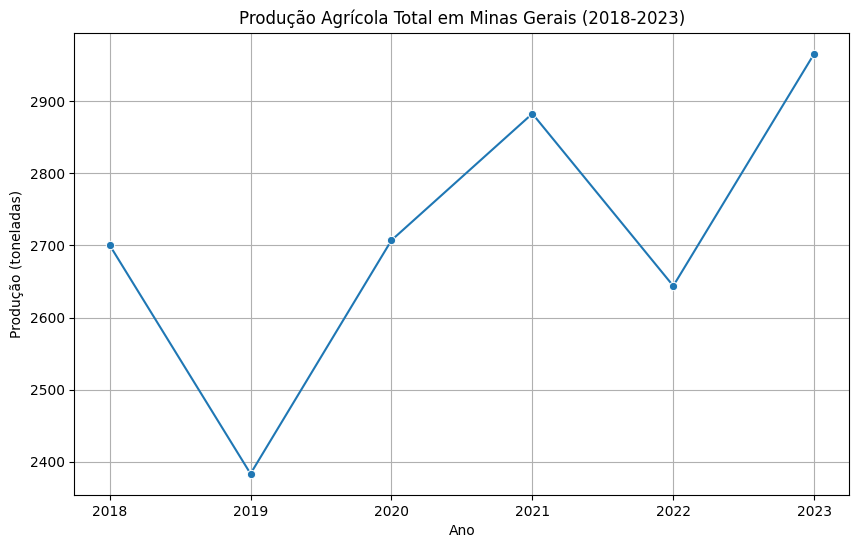

In [36]:
query_producao_ano = f"""
SELECT
  ano,
  SUM(producao_ton) as producao_total,
  COUNT(DISTINCT municipio) as municipios_cobertos
FROM
  {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}
GROUP BY
  ano
ORDER BY
  ano
"""

df_ano = client.query(query_producao_ano).to_dataframe()

# Visualização
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_ano, x='ano', y='producao_total', marker='o')
plt.title('Produção Agrícola Total em Minas Gerais (2018-2023)')
plt.ylabel('Produção (toneladas)')
plt.xlabel('Ano')
plt.grid(True)
plt.show()

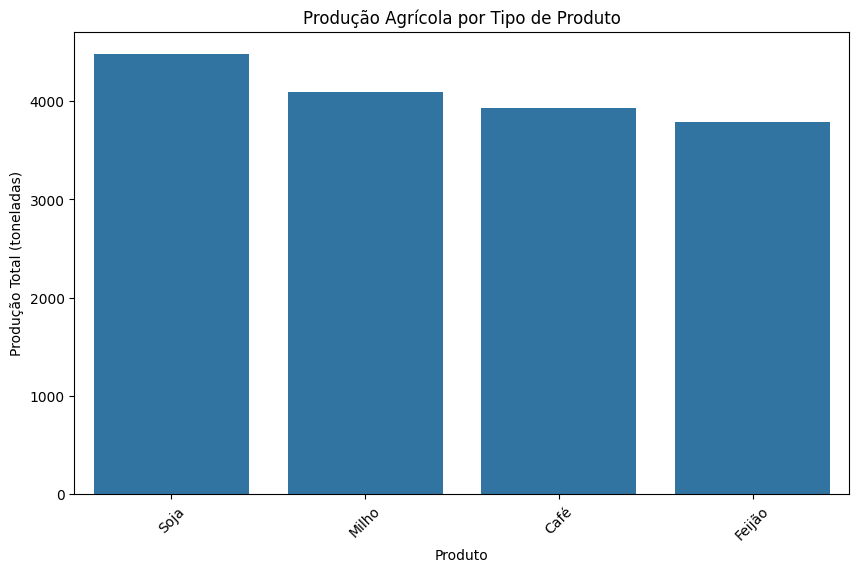

In [37]:
query_ranking = f"""
SELECT
  produto,
  SUM(producao_ton) as producao_total,
  ROUND(AVG(producao_ton), 2) as media_por_municipio
FROM
  {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}
GROUP BY
  produto
ORDER BY
  producao_total DESC
"""

df_ranking = client.query(query_ranking).to_dataframe()

# Visualização
plt.figure(figsize=(10, 6))
sns.barplot(data=df_ranking, x='produto', y='producao_total')
plt.title('Produção Agrícola por Tipo de Produto')
plt.ylabel('Produção Total (toneladas)')
plt.xlabel('Produto')
plt.xticks(rotation=45)
plt.show()

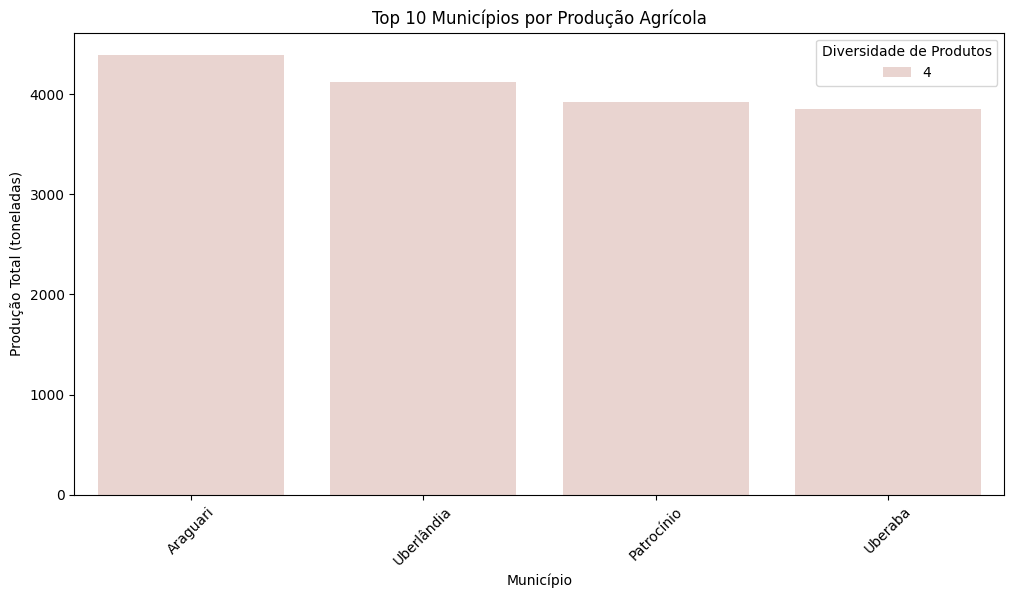

In [38]:
query_municipios = f"""
SELECT
  municipio,
  SUM(producao_ton) as producao_total,
  COUNT(DISTINCT produto) as diversidade_produtos
FROM
  {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}
GROUP BY
  municipio
ORDER BY
  producao_total DESC
LIMIT 10
"""

df_municipios = client.query(query_municipios).to_dataframe()

# Visualização
plt.figure(figsize=(12, 6))
sns.barplot(data=df_municipios, x='municipio', y='producao_total', hue='diversidade_produtos')
plt.title('Top 10 Municípios por Produção Agrícola')
plt.ylabel('Produção Total (toneladas)')
plt.xlabel('Município')
plt.legend(title='Diversidade de Produtos')
plt.xticks(rotation=45)
plt.show()

In [39]:
# Consulta para criar tabela de resultados
query_criar_resultados = f"""
CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET_ID}.resultados_analise AS
SELECT
  ano,
  produto,
  municipio,
  producao_ton,
  producao_ton / NULLIF(SUM(producao_ton) OVER (PARTITION BY ano, produto), 0) * 100 as percentual_ano_produto
FROM
  {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}
"""

client.query(query_criar_resultados).result()
print("✅ Tabela de resultados criada com sucesso")

✅ Tabela de resultados criada com sucesso


In [40]:
# Verificar uso do BigQuery
query_custo = """
SELECT
  SUM(total_bytes_processed) / POW(1024, 3) as GB_processados
FROM
  region-us.INFORMATION_SCHEMA.JOBS_BY_PROJECT
WHERE
  creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY) AND CURRENT_TIMESTAMP()
"""

df_custo = client.query(query_custo).to_dataframe()
print(f"Uso recente: {df_custo.iloc[0]['GB_processados']:.2f} GB processados")

Uso recente: nan GB processados


In [41]:
# Exemplo: Tendência de produção por produto
from scipy import stats

for produto in df_producao['produto'].unique():
    df_temp = df_producao[df_producao['produto'] == produto].groupby('ano')['producao_ton'].sum().reset_index()
    slope, _, _, _, _ = stats.linregress(df_temp['ano'], df_temp['producao_ton'])
    print(f"Tendência anual para {produto}: {slope:.2f} ton/ano")

Tendência anual para Soja: -25.31 ton/ano
Tendência anual para Milho: 53.79 ton/ano
Tendência anual para Café: -3.84 ton/ano
Tendência anual para Feijão: 40.61 ton/ano


In [42]:
# Previsão para próximo ano (método simplificado)
ultimo_ano = df_producao['ano'].max()
df_ultimo_ano = df_producao[df_producao['ano'] == ultimo_ano]

# Aplicar crescimento médio de 5%
df_previsao = df_ultimo_ano.copy()
df_previsao['ano'] = ultimo_ano + 1
df_previsao['producao_ton'] = df_previsao['producao_ton'] * 1.05

# Carregar previsão
carregar_dados_bigquery(df_previsao, 'previsao_producao')

<ipython-input-34-697cb1779f4e>:11: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(


✅ Dados carregados em previsao_producao


True